In [1]:
!pip install sidetable -U

# Project description   

We work at a startup that sells food products. **We need to investigate user behavior for the company's app.**   
Let's define our probable steps and what we are going do with data:    

*Step 1. We'll just take a look on data and prepare and make changes, if needed (working with missing values, incorrect data types, making necessary calculations)   
Step 2. We'll check data in terms of preparing for further A/A/B test.   
Step 3. We'll study the sales funnel: we'll find out how users reach the purchase stage, how many users actually make it to this stage or how many get stuck at previous stages etc.    
Step 4. Then we have to provide an A/A/B test, because designers would like to change the fonts for the entire app, but the managers decide to make a decision based on the results of an A/A/B test: to do or not to do.     
The users are split into three groups: two control groups get the old fonts and one test group gets the new ones. Find out which set of fonts produces better results.*

## Step 1. Look in general on data. Prepare the data for analysis

In [2]:
import pandas as pd
import sidetable
from datetime import datetime
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats
import math as mth

In [3]:
try: 
    data = pd.read_csv('C:/Users/Dell/Documents/tempPy/myProjects/ForGit/AB_test_analysis/logs_exp_us.csv', sep = '\t')
except:
    print('Oops, something wrong')

In [4]:
data.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
138844,MainScreenAppear,1395464111704798775,1564948698,248
162248,MainScreenAppear,7402219874284425208,1565015630,248
146999,OffersScreenAppear,3555990757384986950,1564990966,248
217734,MainScreenAppear,3923636119268104181,1565160514,248
58768,MainScreenAppear,6224840966394928541,1564753051,247
7996,MainScreenAppear,3090628203932190912,1564643747,247
53183,MainScreenAppear,4081374760451203066,1564743702,247
86416,OffersScreenAppear,1035766790164458922,1564829129,246
178344,CartScreenAppear,8898608114522007125,1565062585,247
141152,MainScreenAppear,3167390091686880227,1564965234,247


In [5]:
data.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.9 MB


In [6]:
data.describe(include = 'object')

,EventName
count,244126
unique,5
top,MainScreenAppear
freq,119205


Let's rename columns, change type of timestamp column and add new date column:

In [7]:
data.columns = data.columns.str.lower()
data.columns = ['event_name', 'device_id', 'event_timestamp', 'exp_id']
data.head()

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [8]:
data['event_timestamp'] = data['event_timestamp'].apply(lambda x: datetime.fromtimestamp(x))
data.head()

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248


In [9]:
data['date'] = data['event_timestamp'].dt.date
data.head()

,event_name,device_id,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248,2019-07-25


**Conclusion:**    

So, now it looks more we could proceed for next step

## Step 2. Study and check the data

### How many events are in the logs?

As we could mention before - we have 5 events in the logs

### How many users are in the logs?

In [10]:
data['device_id'].nunique()

7551

### What's the average number of events per user?

In [11]:
data.groupby('device_id')['event_name'].count().mean()

32.33028737915508

In [12]:
data.groupby('device_id')['event_name'].nunique().reset_index()['event_name'].mean()

2.6744802012978415

As we could mention for each particular user it takes nearly 2-3 steps on average.

### What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?

In [13]:
data['event_timestamp'].min()

Timestamp('2019-07-25 07:43:36')

In [14]:
data['event_timestamp'].max()

Timestamp('2019-08-08 00:15:17')

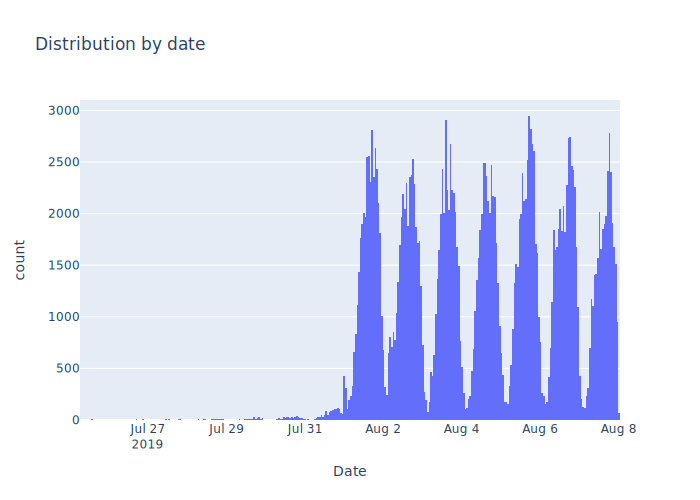

In [53]:
fig = px.histogram(data, x = 'event_timestamp', 
                   title = 'Distribution by date', 
                   labels ={'event_timestamp': 'Date'})
fig.show("svg")

Ok, we see that, apparently, the test begins in the evening of 31st July, as we can note the kind of peak on graph. So, let's assume that the data starts to be complete from the beginning of 1st August. 

In [16]:
actual_data = data[data['event_timestamp'] > '2019-07-31 23:59:59']
actual_data

,event_name,device_id,event_timestamp,exp_id,date
1990,MainScreenAppear,7701922487875823903,2019-08-01 00:00:57,247,2019-08-01
1991,MainScreenAppear,2539077412200498909,2019-08-01 00:01:45,247,2019-08-01
1992,OffersScreenAppear,3286987355161301427,2019-08-01 00:02:21,248,2019-08-01
1993,OffersScreenAppear,3187166762535343300,2019-08-01 00:02:23,247,2019-08-01
1994,MainScreenAppear,1118952406011435924,2019-08-01 00:03:25,248,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-08 00:12:25,247,2019-08-08
244122,MainScreenAppear,5849806612437486590,2019-08-08 00:13:59,246,2019-08-08
244123,MainScreenAppear,5746969938801999050,2019-08-08 00:14:43,246,2019-08-08
244124,MainScreenAppear,5746969938801999050,2019-08-08 00:14:58,246,2019-08-08


### Did you lose many events and users when excluding the older data?

In [17]:
actual_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242136 entries, 1990 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       242136 non-null  object        
 1   device_id        242136 non-null  int64         
 2   event_timestamp  242136 non-null  datetime64[ns]
 3   exp_id           242136 non-null  int64         
 4   date             242136 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.1+ MB


As we could mention, there are 241298 entries after excluding compared with initial data

### Make sure you have users from all three experimental groups.

In [18]:
actual_data['exp_id'].value_counts()

248    85039
246    79679
247    77418
Name: exp_id, dtype: int64

Ok, we sure that we have users in all groups

## Step 3. Study the event funnel

### See what events are in the logs and their frequency of occurrence. Sort them by frequency.

In [19]:
actual_data.groupby('event_name')['device_id'].count().sort_values(ascending = False)

event_name
MainScreenAppear           117992
OffersScreenAppear          46548
CartScreenAppear            42406
PaymentScreenSuccessful     34146
Tutorial                     1044
Name: device_id, dtype: int64

### Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.

In [20]:
actual_data.groupby('event_name')['device_id'].nunique().sort_values(ascending = False)

event_name
MainScreenAppear           7423
OffersScreenAppear         4597
CartScreenAppear           3736
PaymentScreenSuccessful    3540
Tutorial                    843
Name: device_id, dtype: int64

In [21]:
actual_data.groupby('event_name')['device_id'].nunique().sort_values(ascending = False) / actual_data.device_id.nunique()

event_name
MainScreenAppear           0.984744
OffersScreenAppear         0.609843
CartScreenAppear           0.495622
PaymentScreenSuccessful    0.469621
Tutorial                   0.111833
Name: device_id, dtype: float64

Only 60% have done next stage after Main screen appearing

### Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)

In [22]:
funnel = actual_data.groupby('event_name')['device_id'].nunique().sort_values(ascending = False).reset_index()
funnel

,event_name,device_id
0,MainScreenAppear,7423
1,OffersScreenAppear,4597
2,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540
4,Tutorial,843


In [23]:
funnel['per_ch'] = funnel['device_id'].pct_change()
funnel

,event_name,device_id,per_ch
0,MainScreenAppear,7423,NaN
1,OffersScreenAppear,4597,-0.380709
2,CartScreenAppear,3736,-0.187296
3,PaymentScreenSuccessful,3540,-0.052463
4,Tutorial,843,-0.761864


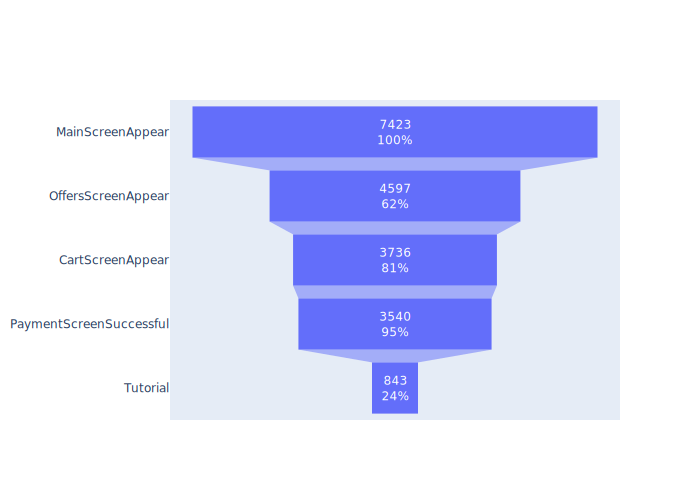

In [54]:
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['device_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.show("svg")

So, we could mention that the majority of losses are after the first stage - almost 38% we lose from between Main Screen and Offer Screen. After offer screen appearing the following events have pretty high percentages: 81% and 91% respectively. Also, we can say, that stage "Tutorial" appears after payment, that probably means this stage is the most skipped part of our funnel. Let's assume that we're not going to include this stage in the funnel. 

Now, let's see how the funnel looks like for each group particularly

In [25]:
ctlGroup1 = (actual_data[actual_data['exp_id'] == 246]
              .groupby(['event_name', 'exp_id'])['device_id'].nunique().sort_values(ascending = False).reset_index())
ctlGroup1

,event_name,exp_id,device_id
0,MainScreenAppear,246,2450
1,OffersScreenAppear,246,1542
2,CartScreenAppear,246,1266
3,PaymentScreenSuccessful,246,1200
4,Tutorial,246,278


In [26]:
ctlGroup2 = (actual_data[actual_data['exp_id'] == 247]
              .groupby(['event_name', 'exp_id'])['device_id'].nunique().sort_values(ascending = False).reset_index())
ctlGroup2

,event_name,exp_id,device_id
0,MainScreenAppear,247,2479
1,OffersScreenAppear,247,1524
2,CartScreenAppear,247,1239
3,PaymentScreenSuccessful,247,1158
4,Tutorial,247,284


In [27]:
testGroup = (actual_data[actual_data['exp_id'] == 248]
             .groupby(['event_name', 'exp_id'])['device_id'].nunique().sort_values(ascending = False).reset_index())
testGroup

,event_name,exp_id,device_id
0,MainScreenAppear,248,2494
1,OffersScreenAppear,248,1531
2,CartScreenAppear,248,1231
3,PaymentScreenSuccessful,248,1182
4,Tutorial,248,281


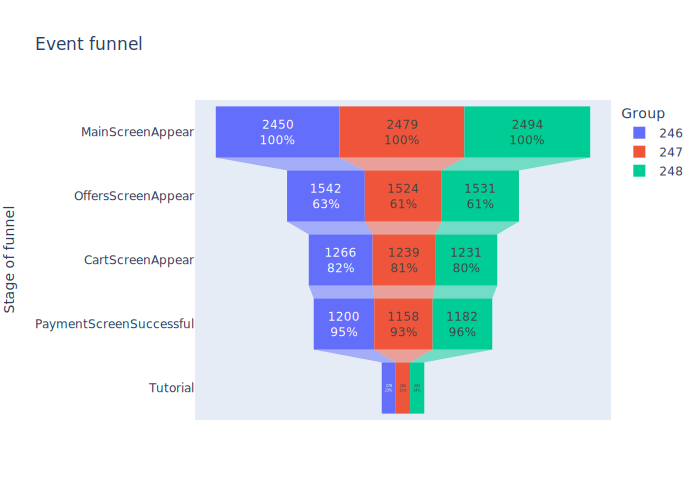

In [55]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = '246',
    orientation = "h",
    y = ctlGroup1['event_name'],
    x = ctlGroup1['device_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = '247',
    orientation = "h",
    y = ctlGroup2['event_name'],
    x = ctlGroup2['device_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.add_trace(go.Funnel(
    name = '248',
    orientation = "h",
    y = testGroup['event_name'],
    x = testGroup['device_id'],
    textposition = "inside",
    textinfo = "value+percent previous"))

fig.update_layout(title = 'Event funnel', 
                  yaxis_title="Stage of funnel", 
                  legend_title="Group",)

fig.show("svg")

So, it seems that test group has almost the same results as control groups in terms of share between stages. The differences vary between 1-2 % for each stage. 

### At what stage do you lose the most users?

As we mentioned above - on "Offer Screen Appear" we lose the majority of users - nearly 38%

### What share of users make the entire journey from their first event to payment?

Only 37,7 % of users came to the final stage of funnel. 

## Step 4. Study the results of the experiment

### How many users are there in each group?

In [29]:
actual_data.groupby(['exp_id'])['device_id'].nunique()

exp_id
246    2484
247    2517
248    2537
Name: device_id, dtype: int64

Let's check do we have the same users in several test groups?

In [30]:
actual_data.groupby('device_id')['exp_id'].nunique().reset_index().query('exp_id > 1')

,device_id,exp_id


The table is empty so, we didn't

### We have two control groups in the A/A test, where we check our mechanisms and calculations. See if there is a statistically significant difference between samples 246 and 247.

We'll declare hypotheses in the following way:   
1. H0 (Null): **There is NO statistically significant difference between the two groups**    

2. H1 (Alternative): **Yes, statistically significant difference exists**

We'll create the samples

In [31]:
test_1=actual_data[actual_data.exp_id==246]['device_id'].unique()
test_2=actual_data[actual_data.exp_id==247]['device_id'].unique()

Let's create a function where we'll include all possible variants of the test in terms of checking normality and what particular test we would use for.

In [32]:
def check_diff(sample1,sample2,alpha=0.05):
    stat1, p1_norm=stats.shapiro(sample1)
    stat2, p2_norm=stats.shapiro(sample2)
    if p1_norm > alpha and p2_norm>alpha:
        statslev,p_levene=stats.levene(sample1, sample2)
        if p_levene<alpha:
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=False)
        else:
            statist,p_value=stats.ttest_ind(sample1, sample2,equal_var=True) 
    else:
        statist,p_value=stats.mannwhitneyu(sample1, sample2)
    print(p_value)
    if p_value<alpha:
        print('Rejecting the null hypothesis')
    else:
        print('Failed to reject the null hypothesis')

In [33]:
check_diff(test_1, test_2,alpha=0.05)

0.734765634444638
Failed to reject the null hypothesis


**Conclusion:**

So, we actually proved that there is no statistically significant difference between samples 246 and 247

### Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?

First let's create a pivot table just to see how many users were achieved the particular event in the particular group

In [34]:
piv_data=actual_data.pivot_table(index='event_name', 
                                 columns='exp_id',values='device_id',aggfunc='nunique').reset_index()
piv_data

exp_id,event_name,246,247,248
0,CartScreenAppear,1266,1239,1231
1,MainScreenAppear,2450,2479,2494
2,OffersScreenAppear,1542,1524,1531
3,PaymentScreenSuccessful,1200,1158,1182
4,Tutorial,278,284,281


Now, let's write the next one function for checking is the share of users (from all users in the test) that had accomplished particular event of one test group is statistically different from another?

In [35]:
def check_share(group1,group2,event,alpha=0.05):
    success1=piv_data[piv_data.event_name==event][group1].iloc[0]
    success2=piv_data[piv_data.event_name==event][group2].iloc[0]
    
    trials1=actual_data[actual_data.exp_id==group1]['device_id'].nunique()
    trials2=actual_data[actual_data.exp_id==group2]['device_id'].nunique()
    
    p1 = success1/trials1
    p2 = success2/trials2

    p_combined = (success1 + success2) / (trials1 + trials2)

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis for", event,"and groups", group1,group2)
    else:
        print("Failed to reject the null hypothesis for",event,"and groups", group1,group2)

And again, we'll declare hypotheses in the following way:   
1. H0 (Null): **There is NO statistically significant difference between the two groups**    

2. H1 (Alternative): **Yes, statistically significant difference exists**

In [36]:
check_share(246,247,'MainScreenAppear',alpha=0.05)

p-value:  0.6756217702005545
Failed to reject the null hypothesis for MainScreenAppear and groups 246 247


Ok, for the most popular event we can declare that there is no statistically significant difference between group 246 and 247 and for action "MainScreenAppear".    
Let's accomplish this test for another ones 

In [37]:
check_share(246,247,'OffersScreenAppear',alpha=0.05)

p-value:  0.26698769175859516
Failed to reject the null hypothesis for OffersScreenAppear and groups 246 247


In [38]:
check_share(246, 247, 'CartScreenAppear', alpha=0.05)

p-value:  0.2182812140633792
Failed to reject the null hypothesis for CartScreenAppear and groups 246 247


In [39]:
check_share(246, 247, 'PaymentScreenSuccessful', alpha=0.05)

p-value:  0.10298394982948822
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups 246 247


In [40]:
check_share(246, 247, 'Tutorial', alpha = 0.05)

p-value:  0.9182790262812368
Failed to reject the null hypothesis for Tutorial and groups 246 247


**Conclusion:**   

For each event we could say that there is no statistically significant difference between groups 246 and 247 and we can confirm that the groups were split properly

### Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?

Let's at first compare results for each event between groups 246 and 248

In [41]:
for i in piv_data.event_name.unique():
    check_share(246,248,i,alpha=0.05)

p-value:  0.08328412977507749
Failed to reject the null hypothesis for CartScreenAppear and groups 246 248
p-value:  0.34705881021236484
Failed to reject the null hypothesis for MainScreenAppear and groups 246 248
p-value:  0.20836205402738917
Failed to reject the null hypothesis for OffersScreenAppear and groups 246 248
p-value:  0.22269358994682742
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups 246 248
p-value:  0.8964489622133207
Failed to reject the null hypothesis for Tutorial and groups 246 248


And for groups 247 and 248

In [42]:
for i in piv_data.event_name.unique():
    check_share(247,248,i,alpha=0.05)

p-value:  0.6169517476996997
Failed to reject the null hypothesis for CartScreenAppear and groups 247 248
p-value:  0.6001661582453706
Failed to reject the null hypothesis for MainScreenAppear and groups 247 248
p-value:  0.8835956656016957
Failed to reject the null hypothesis for OffersScreenAppear and groups 247 248
p-value:  0.6775413642906454
Failed to reject the null hypothesis for PaymentScreenSuccessful and groups 247 248
p-value:  0.8151967015119994
Failed to reject the null hypothesis for Tutorial and groups 247 248


Comparing both test groups in isolation with control group we've got that they are all the same: there is no statistically significant difference neither between group 246 and 248 nor between 247 and 248.

Now we'll compare the results with the combined results for the control groups. First, we'll separate control and test groups into particular DataFrame 

In [43]:
combined_test = actual_data.query('exp_id == 246 or exp_id == 247')
combined_test

,event_name,device_id,event_timestamp,exp_id,date
1990,MainScreenAppear,7701922487875823903,2019-08-01 00:00:57,247,2019-08-01
1991,MainScreenAppear,2539077412200498909,2019-08-01 00:01:45,247,2019-08-01
1993,OffersScreenAppear,3187166762535343300,2019-08-01 00:02:23,247,2019-08-01
1996,OffersScreenAppear,3511569580412335882,2019-08-01 00:06:12,246,2019-08-01
1997,OffersScreenAppear,3511569580412335882,2019-08-01 00:07:16,246,2019-08-01
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,2019-08-08 00:12:25,247,2019-08-08
244122,MainScreenAppear,5849806612437486590,2019-08-08 00:13:59,246,2019-08-08
244123,MainScreenAppear,5746969938801999050,2019-08-08 00:14:43,246,2019-08-08
244124,MainScreenAppear,5746969938801999050,2019-08-08 00:14:58,246,2019-08-08


In [44]:
piv_comb_test = combined_test.pivot_table(index = 'event_name', values = 'device_id', aggfunc = 'nunique').reset_index()
piv_comb_test

,event_name,device_id
0,CartScreenAppear,2505
1,MainScreenAppear,4929
2,OffersScreenAppear,3066
3,PaymentScreenSuccessful,2358
4,Tutorial,562


In [45]:
control = actual_data.query('exp_id == 248')
control

,event_name,device_id,event_timestamp,exp_id,date
1992,OffersScreenAppear,3286987355161301427,2019-08-01 00:02:21,248,2019-08-01
1994,MainScreenAppear,1118952406011435924,2019-08-01 00:03:25,248,2019-08-01
1995,MainScreenAppear,929387516286850088,2019-08-01 00:05:35,248,2019-08-01
2001,MainScreenAppear,929387516286850088,2019-08-01 00:07:51,248,2019-08-01
2002,MainScreenAppear,929387516286850088,2019-08-01 00:08:04,248,2019-08-01
...,...,...,...,...,...
244082,MainScreenAppear,8249271441488197538,2019-08-08 00:03:33,248,2019-08-08
244084,OffersScreenAppear,8249271441488197538,2019-08-08 00:03:43,248,2019-08-08
244109,MainScreenAppear,5317814261427487562,2019-08-08 00:09:22,248,2019-08-08
244110,OffersScreenAppear,5317814261427487562,2019-08-08 00:09:27,248,2019-08-08


In [46]:
piv_control = control.pivot_table(index = 'event_name', values = 'device_id', aggfunc = 'nunique').reset_index()
piv_control

,event_name,device_id
0,CartScreenAppear,1231
1,MainScreenAppear,2494
2,OffersScreenAppear,1531
3,PaymentScreenSuccessful,1182
4,Tutorial,281


Let's adjust little bit function 

In [47]:
def check_share_comb(event,alpha=0.05):
    success1=piv_comb_test[piv_comb_test.event_name==event]['device_id'].iloc[0]
    success2=piv_control[piv_control.event_name==event]['device_id'].iloc[0]
    
    trials1=combined_test['device_id'].nunique()
    trials2=control['device_id'].nunique()
    
    p1 = success1/trials1
    p2 = success2/trials2

    p_combined = (success1 + success2) / (trials1 + trials2)

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis for", event)
    else:
        print("Failed to reject the null hypothesis for",event)

In [48]:
for i in piv_control.event_name.unique():
    check_share_comb(i,alpha=0.05)

p-value:  0.19819340844527744
Failed to reject the null hypothesis for CartScreenAppear
p-value:  0.39298914928006035
Failed to reject the null hypothesis for MainScreenAppear
p-value:  0.418998284007599
Failed to reject the null hypothesis for OffersScreenAppear
p-value:  0.6452057673098244
Failed to reject the null hypothesis for PaymentScreenSuccessful
p-value:  0.8333049080125807
Failed to reject the null hypothesis for Tutorial


So, we see, that there is no statistically significant difference between combined control and test groups. It might make sense that our hypothesis with fonts doesn't work 

### What significance level have you set to test the statistical hypotheses mentioned above? Calculate how many statistical hypothesis tests you carried out. With a statistical significance level of 0.1, one in 10 results could be false. What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.

According to the theory that we've passed, doing hypothesis tests we might face two types of errors:   
- Type 1 (Null hypothesis wrongly rejected)   
- Type 2 (Null hypothesis wrongly accepted)   

To avoid that we have to make correlation by using one of method and the **Bonferroni correction** is the most common because of its simplicity. So, we have to reduce alpha value by dividing him into the number of tests that we carried out. It has to look like:    
bonferroni_alpha = alpha / number of tests   

It is little bit weird, because the p_value that we retrieve all time more than alpha value. And reducing alpha value doesn't give us anything, but let's consider our last test, we have to set correction with 5 tests 

In [49]:
def check_share_comb1(event,alpha=0.01):
    success1=piv_comb_test[piv_comb_test.event_name==event]['device_id'].iloc[0]
    success2=piv_control[piv_control.event_name==event]['device_id'].iloc[0]
    
    trials1=combined_test['device_id'].nunique()
    trials2=control['device_id'].nunique()
    
    p1 = success1/trials1
    p2 = success2/trials2

    p_combined = (success1 + success2) / (trials1 + trials2)

    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Rejecting the null hypothesis for", event)
    else:
        print("Failed to reject the null hypothesis for",event)

In [50]:
for i in piv_control.event_name.unique():
    check_share_comb1(i,alpha=0.01)

p-value:  0.19819340844527744
Failed to reject the null hypothesis for CartScreenAppear
p-value:  0.39298914928006035
Failed to reject the null hypothesis for MainScreenAppear
p-value:  0.418998284007599
Failed to reject the null hypothesis for OffersScreenAppear
p-value:  0.6452057673098244
Failed to reject the null hypothesis for PaymentScreenSuccessful
p-value:  0.8333049080125807
Failed to reject the null hypothesis for Tutorial


As I've mentioned above, we still have retrieved two groups with no statistically significant difference between them. 

**Conclusion:**   

Ok, based on several results of A/A/B test we could say that there is no evidence of increasing sales after fonts have been changed.   
First, our sales funnel looks similar in terms of dividing into three groups, the percentage between stages varies into 1-2%. The most significant loss of leads is between Main Screen and Offer screen.   
Also, in all proportion test the results were the same: there is no statistically significant difference neither than we compare two test groups with control in isolation nor between combined test group and control as well. Even if we'll decrease statistical significance level, we'll obtain the same outcomes   